In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import mlflow
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv(r"C:\Users\psxea2\Desktop\Amdari files\ElectroTech-Forecasting-Data\DataCleaning\cleaned_data.csv", parse_dates=['Date'])

In [4]:
data.columns

Index(['Product_ID', 'Category', 'Price', 'Date', 'Season',
       'Market_Trend_Index', 'Competitor_Activity_Score',
       'Consumer_Confidence_Index', 'Product_Specification_1',
       'Product_Specification_2', 'Sales_Volume', 'Total_Amount', 'Recency',
       'Frequency', 'Monetary', 'Sales_Volume_lag1', 'Sales_Volume_lag7',
       'Sales_Volume_lag30', 'Price_lag1', 'Price_lag7', 'Price_lag30',
       'Market_Trend_Index_lag1', 'Market_Trend_Index_lag7',
       'Market_Trend_Index_lag30', 'Competitor_Activity_Score_lag1',
       'Competitor_Activity_Score_lag7', 'Competitor_Activity_Score_lag30',
       'Consumer_Confidence_Index_lag1', 'Consumer_Confidence_Index_lag7',
       'Consumer_Confidence_Index_lag30'],
      dtype='object')

In [5]:
data['Date'].max()

Timestamp('2020-12-30 00:00:00')

In [6]:
data['Date'].min()

Timestamp('2010-02-10 00:00:00')

In [7]:
data.select_dtypes(include=['object']).columns

Index(['Category', 'Season', 'Product_Specification_1',
       'Product_Specification_2'],
      dtype='object')

In [8]:
data['Season'].value_counts()

Season
Fall      29472
Summer    28857
Spring    28640
Winter    28404
Name: count, dtype: int64

In [12]:
data['Date'] = pd.to_datetime(data['Date'])
data= data.sort_values('Date')

data['Date'].diff().value_counts().head()

Date
0 days    111452
1 days      3900
2 days         9
3 days         3
4 days         2
Name: count, dtype: int64

##  Training

In [13]:
df = data.copy()

df['Date'] = pd.to_datetime(df['Date'])

ts = (
    df
    .groupby('Date')['Sales_Volume']
    .sum()
)
    
ts = ts.asfreq('M')   


In [14]:
ts.isna().sum()

np.int64(3)

In [15]:
ts = ts.fillna(0)

In [16]:
seasonal_period = 12

#### split the data : We used a time-based split, training on earlier years and evaluating on the most recent period to simulate real-world forecasting.

In [17]:
#  training on data up to 2018 and evaluate on forecast using data from 2019 onwards


train = ts[:'2018-12-31']
test  = ts['2019-01-01':]

#### Model fitting

##### baseline :simple exponential smoothing

In [18]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

naive_model = SimpleExpSmoothing(train).fit()
naive_forecast = naive_model.forecast(len(test))

##### Exponential smoothing

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

ets_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

ets_forecast = ets_model.forecast(len(test))

##### SARIMA

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

sarima_forecast = sarima_model.forecast(len(test))

#### Model Evaluation 

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate(y_true, y_pred, name):
    return {
        'Model': name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred))
    }

results = pd.DataFrame([
    evaluate(test, naive_forecast, 'Naive'),
    evaluate(test, ets_forecast, 'ETS'),
    evaluate(test, sarima_forecast, 'SARIMA')
])

results

,Model,MAE,RMSE
0,Naive,1386.517806,1772.704468
1,ETS,1272.613396,1573.500646
2,SARIMA,1233.873138,1511.459093


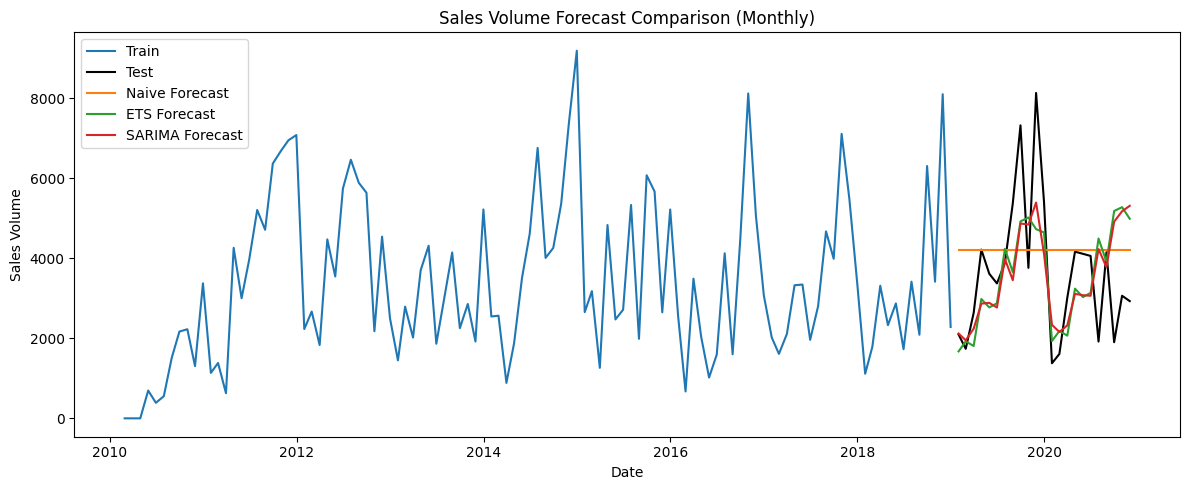

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='black')

plt.plot(test.index, naive_forecast, label='Naive Forecast')
plt.plot(test.index, ets_forecast, label='ETS Forecast')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')

plt.title('Sales Volume Forecast Comparison (Monthly)')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.tight_layout()
plt.show()

We benchmarked a simple baseline model, simple exponential smoothing against Exponential Smoothing and SARIMA using a time-based train–test split. Both seasonal models significantly improved forecast accuracy. SARIMA achieved the lowest MAE and RMSE, indicating the best out-of-sample performance, and was therefore selected as the final model.    ETS performed well and is simpler, but SARIMA consistently achieved lower forecast error, so we prioritised accuracy for this use case.        

Sales are dominated by seasonality, not long-term trend

##### save the best model

In [ ]:
import pickle

with open(r'\model\sarima_sales_volume_model.pkl', 'wb') as f:
    pickle.dump(sarima_model, f)

#### Extending this to include SARIMAX performance using MLFlow

In [23]:
import mlflow
import mlflow.statsmodels

In [24]:
y_train = train
y_test = test

In [25]:
#define exogenous  variables
exog_cols = [
    'Price',
    'Market_Trend_Index',
    'Competitor_Activity_Score',
    'Consumer_Confidence_Index'
]

In [26]:
# aggregate exogenous variables monthly

exog = (
    df
    .groupby(pd.Grouper(key='Date', freq='M'))[exog_cols]
    .mean()
    .asfreq('M')
    .fillna(method='ffill')
)

In [ ]:
#align exogenous variables with training and testing sets
exog_train = exog.loc[y_train.index]
exog_test  = exog.loc[y_test.index]

In [32]:
# Set mlflow experiment

mlflow.set_experiment("Sales_Forecasting_SARIMAX")

<Experiment: artifact_location=('file:c:/Users/psxea2/Desktop/Amdari '
 'files/ElectroTech-Forecasting-Data/model/mlruns/1'), creation_time=1766001498139, experiment_id='1', last_update_time=1766001498139, lifecycle_stage='active', name='Sales_Forecasting_SARIMAX', tags={}>

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

with mlflow.start_run(run_name="SARIMAX_with_exogenous"):

    order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 12)

    model = SARIMAX(
        y_train,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit()

    preds = model.forecast(
        steps=len(y_test),
        exog=exog_test
    )

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    # Log parameters
    mlflow.log_param("order", order)
    mlflow.log_param("seasonal_order", seasonal_order)
    mlflow.log_param("exogenous_variables", exog_cols)

    # Log metrics
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)

    # Log model
    mlflow.statsmodels.log_model(model, name="sarimax_model")

In [34]:
with mlflow.start_run(run_name="SARIMA_baseline"):

    model = SARIMAX(
        y_train,
        order=(1,1,1),
        seasonal_order=(1,1,1,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit()

    preds = model.forecast(len(y_test))

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)

    mlflow.statsmodels.log_model(model, name="sarima_model")